In [72]:
#!/home/was966/micromamba/envs/responder/bin/python
#sbatch --mem 64G -c 4 -t 12:00:00 -p gpu_quad --gres=gpu:rtx8000:1 ./01_cohort_to_cohort_transfer.py

import sys

sys.path.insert(0, '/home/was966/Research/mims-conceptor/')
from conceptor.utils import plot_embed_with_label
from conceptor import PreTrainer, FineTuner, loadconceptor #, get_minmal_epoch
from conceptor.utils import plot_embed_with_label, score2
from conceptor.tokenizer import CANCER_CODE

import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.3)
import warnings
warnings.filterwarnings("ignore")

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan].astype(bool)].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [73]:
pwd

'/home/was966/Research/mims-conceptor/baseline'

In [74]:
data_path = '../paper/00_data/'
df_label = pd.read_pickle(os.path.join(data_path, 'ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ITRP.TPM.TABLE'))

df_task = onehot(df_label.response_label)
size = df_label.groupby('cohort').size()
size = size.index + "\n(n=" + size.astype(str) + ")"

dfcx = df_label.cancer_type.map(CANCER_CODE).to_frame('cancer_code').join(df_tpm)
dfy = df_task
cohorts = df_label.groupby('cohort').size().sort_values().index.tolist()

size.loc[cohorts]

cohort
Choueiri           Choueiri\n(n=16)
Miao                   Miao\n(n=17)
Snyder               Snyder\n(n=21)
SU2CLC2             SU2CLC2\n(n=25)
Zhao                   Zhao\n(n=25)
Hugo                   Hugo\n(n=26)
MGH                     MGH\n(n=34)
Allen                 Allen\n(n=39)
Kim                     Kim\n(n=45)
Riaz                   Riaz\n(n=51)
Gide                   Gide\n(n=73)
Rose                   Rose\n(n=89)
SU2CLC1            SU2CLC1\n(n=102)
Liu                    Liu\n(n=107)
IMmotion150    IMmotion150\n(n=165)
IMVigor210      IMVigor210\n(n=298)
dtype: object

In [75]:
cohorts = pd.Series(cohorts).map(size).to_list()

## loading bechmarks

In [76]:
from glob import glob
csvs = glob('./experiment_results/LOO_*/*.csv')

res = []
for csv in csvs:
    if 'performance.csv' in csv:
        continue
    df = pd.read_csv(csv, index_col =0)
    df['mode'] = csv.split('/')[-2].split('_')[-1]
    df['cohort'] = size.loc[csv.split('/')[-1].replace('.csv', '')]
    res.append(df)

data1 = pd.concat(res)
data1.head()

,NR,R,0,1,best_C,cohort,mode
Index,,,,,,,
MEL-IPI_Pat03-Tumor-SM-4DJZY,1.0,0.0,0.490932,0.509068,0.1,Allen\n(n=39),CAF
MEL-IPI_Pat06-Tumor-SM-4DK12,1.0,0.0,0.500297,0.499703,0.1,Allen\n(n=39),CAF
MEL-IPI_Pat08-Tumor-SM-4DK14,1.0,0.0,0.499075,0.500925,0.1,Allen\n(n=39),CAF
MEL-IPI_Pat14-Tumor-SM-53U3C,1.0,0.0,0.493740,0.506260,0.1,Allen\n(n=39),CAF
MEL-IPI_Pat15-Tumor-SM-4DK1B,1.0,0.0,0.506011,0.493989,0.1,Allen\n(n=39),CAF


## loading conceptor

In [77]:
csvs = glob('../paper/01_model_performance/00_within-cohort-leave-one-out//LOO_*_*/*.csv')
res = []
for csv in csvs:
    if 'performance.csv' in csv:
        continue
    df = pd.read_csv(csv, index_col =0)
    df['mode'] = csv.split('/')[-2].split('_')[-2]
    df['cohort'] = size.loc[csv.split('/')[-1].replace('.csv', '')]
    res.append(df)

data2 = pd.concat(res)
data2.head()

,NR,R,0,1,best_epoch,mode,cohort,n_trainable_params,seed,batch_size,task_dense_layer
Index,,,,,,,,,,,
MEL-IPI_Pat03-Tumor-SM-4DJZY,1.0,0.0,0.589326,0.410674,17.0,FFT,Allen\n(n=39),NaN,NaN,NaN,NaN
MEL-IPI_Pat06-Tumor-SM-4DK12,1.0,0.0,0.080339,0.919661,22.0,FFT,Allen\n(n=39),NaN,NaN,NaN,NaN
MEL-IPI_Pat08-Tumor-SM-4DK14,1.0,0.0,0.930050,0.069950,8.0,FFT,Allen\n(n=39),NaN,NaN,NaN,NaN
MEL-IPI_Pat14-Tumor-SM-53U3C,1.0,0.0,0.935734,0.064266,21.0,FFT,Allen\n(n=39),NaN,NaN,NaN,NaN
MEL-IPI_Pat15-Tumor-SM-4DK1B,1.0,0.0,0.922681,0.077319,10.0,FFT,Allen\n(n=39),NaN,NaN,NaN,NaN


## Merge & analysis

In [78]:
data = data2._append(data1)
data = data.reset_index()
data.head()

,Index,NR,R,0,1,best_epoch,mode,cohort,n_trainable_params,seed,batch_size,task_dense_layer,best_C
0,MEL-IPI_Pat03-Tumor-SM-4DJZY,1.0,0.0,0.589326,0.410674,17.0,FFT,Allen\n(n=39),NaN,NaN,NaN,NaN,NaN
1,MEL-IPI_Pat06-Tumor-SM-4DK12,1.0,0.0,0.080339,0.919661,22.0,FFT,Allen\n(n=39),NaN,NaN,NaN,NaN,NaN
2,MEL-IPI_Pat08-Tumor-SM-4DK14,1.0,0.0,0.930050,0.069950,8.0,FFT,Allen\n(n=39),NaN,NaN,NaN,NaN,NaN
3,MEL-IPI_Pat14-Tumor-SM-53U3C,1.0,0.0,0.935734,0.064266,21.0,FFT,Allen\n(n=39),NaN,NaN,NaN,NaN,NaN
4,MEL-IPI_Pat15-Tumor-SM-4DK1B,1.0,0.0,0.922681,0.077319,10.0,FFT,Allen\n(n=39),NaN,NaN,NaN,NaN,NaN


In [79]:
dfp = data.groupby(['cohort', 'mode']).apply(lambda x: score2(x['R'], x['1'],
                                                             x[['0', '1']].idxmax(axis=1).astype(int)))
dfp = dfp.apply(pd.Series)
dfp.columns = ['ROC', 'PRC', 'F1', 'ACC','MCC']
dfp = dfp.reset_index()
dfp['size'] = dfp.cohort.apply(lambda x:x.split('n=')[-1].replace(')', ''))
dfp['size'] = dfp['size'].astype(int)
def cohort_size(x):
    if x <= 30:
       s = 'small'
    elif 100 > x > 30:
        s = 'median'
    elif x > 100:
        s = 'large'
    return s
dfp['size_map'] = dfp['size'].map(cohort_size)
dfp.head()

,cohort,mode,ROC,PRC,F1,ACC,MCC,size,size_map
0,Allen\n(n=39),CAF,0.357988,0.262810,0.370370,0.564103,0.037796,39,median
1,Allen\n(n=39),CD8,0.579882,0.369362,0.500000,0.641026,0.223607,39,median
2,Allen\n(n=39),CIS,0.644970,0.413898,0.500000,0.641026,0.223607,39,median
3,Allen\n(n=39),CKS,0.627219,0.380957,0.482759,0.615385,0.184302,39,median
4,Allen\n(n=39),CTL,0.627219,0.398782,0.482759,0.615385,0.184302,39,median


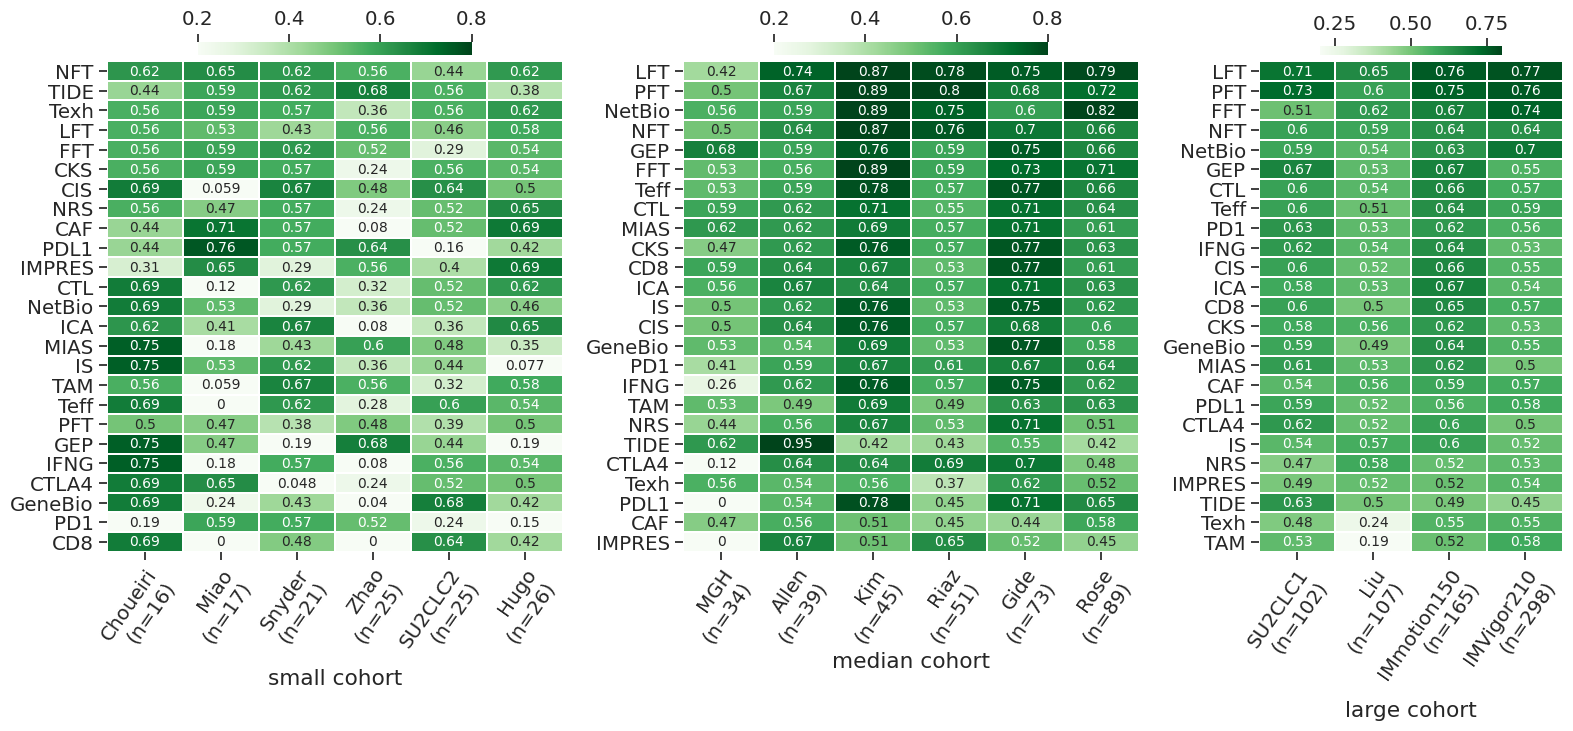

In [80]:
values = 'ACC'

fig,axes = plt.subplots(figsize=(16,8), ncols=3, sharey=False, width_ratios = [6,6,4])
ax1, ax2, ax3 = axes


for s, ax in zip(['small', 'median', 'large'], axes):
    
    dfp1 = dfp[dfp['size_map'] == s]
    x_order = dfp1.sort_values('size').cohort.unique()
    data2d = pd.pivot_table(dfp1, index='mode', columns = 'cohort', values = values)
    modes = dfp1.groupby('mode')[values].mean().sort_values(ascending=False).index.to_list()
    data2d = data2d[x_order]
    data2d = data2d.loc[modes]

    cbar_kws=dict(location="top",pad=0.01,shrink=0.6)
    
    sns.heatmap(data2d, cmap = 'Greens', vmax = 0.8, vmin = 0.2, ax=ax, cbar_kws = cbar_kws,
                linewidths = 0.1, annot=True, annot_kws = {'fontsize':10})
    
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax.set_xticklabels(
        x_order, 
        rotation=55, 
        ha="right",  
        rotation_mode="anchor")  # <====== HERE is the ke
    
    ax.set_xlabel('%s cohort' % s)
    ax.set_ylabel('')
    
    # ax.set_ylim(0,1)

#ax.set_title('LOO %s' % values)

fig.tight_layout()

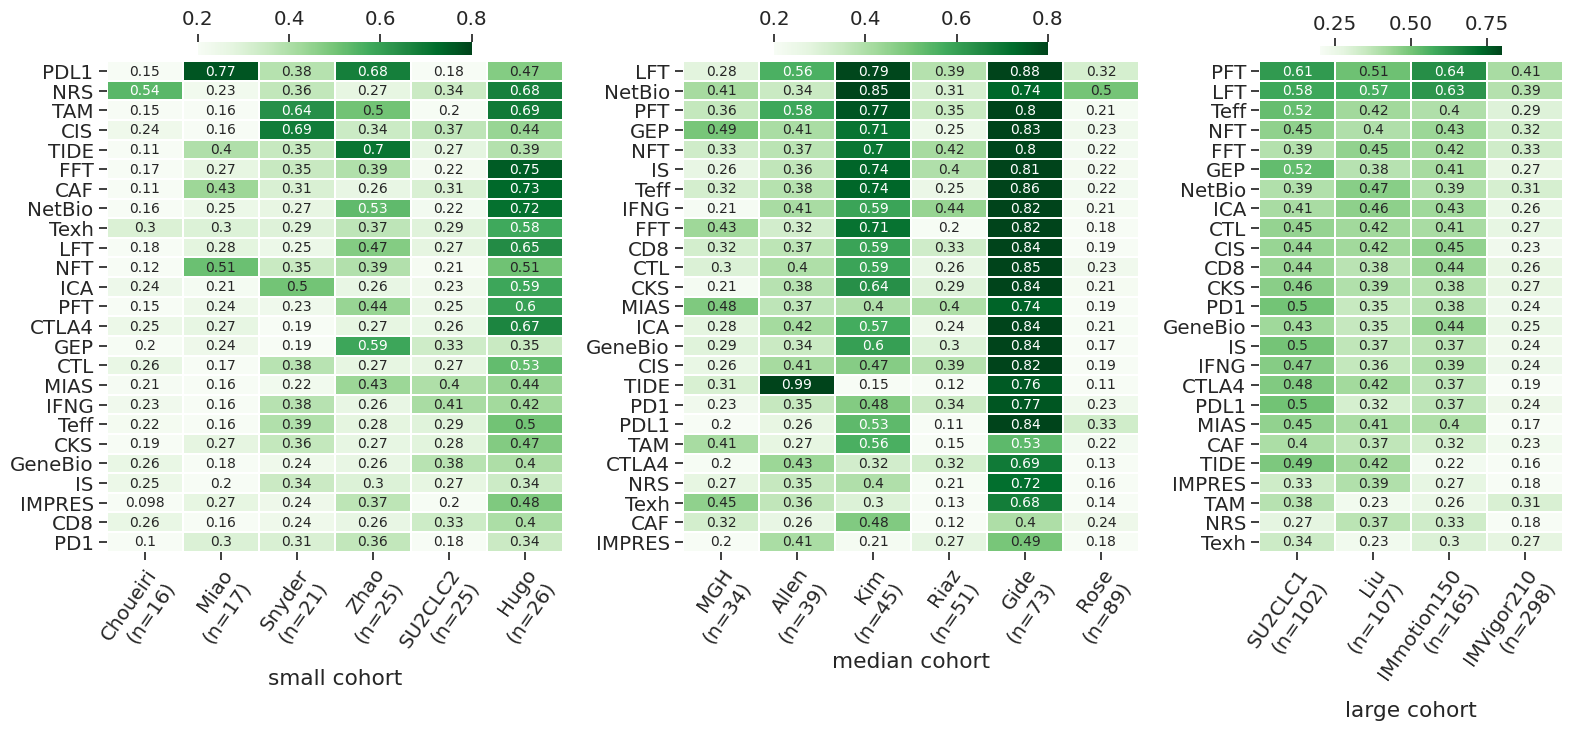

In [83]:
values = 'PRC'

fig,axes = plt.subplots(figsize=(16,8), ncols=3, sharey=False, width_ratios = [6,6,4])
ax1, ax2, ax3 = axes


for s, ax in zip(['small', 'median', 'large'], axes):
    
    dfp1 = dfp[dfp['size_map'] == s]
    x_order = dfp1.sort_values('size').cohort.unique()
    data2d = pd.pivot_table(dfp1, index='mode', columns = 'cohort', values = values)
    modes = dfp1.groupby('mode')[values].mean().sort_values(ascending=False).index.to_list()
    data2d = data2d[x_order]
    data2d = data2d.loc[modes]

    cbar_kws=dict(location="top",pad=0.01,shrink=0.6)
    
    sns.heatmap(data2d, cmap = 'Greens', vmax = 0.8, vmin = 0.2, ax=ax, cbar_kws = cbar_kws,
                linewidths = 0.1, annot=True, annot_kws = {'fontsize':10})
    
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax.set_xticklabels(
        x_order, 
        rotation=55, 
        ha="right",  
        rotation_mode="anchor")  # <====== HERE is the ke
    
    ax.set_xlabel('%s cohort' % s)
    ax.set_ylabel('')
    
    # ax.set_ylim(0,1)

#ax.set_title('LOO %s' % values)

fig.tight_layout()

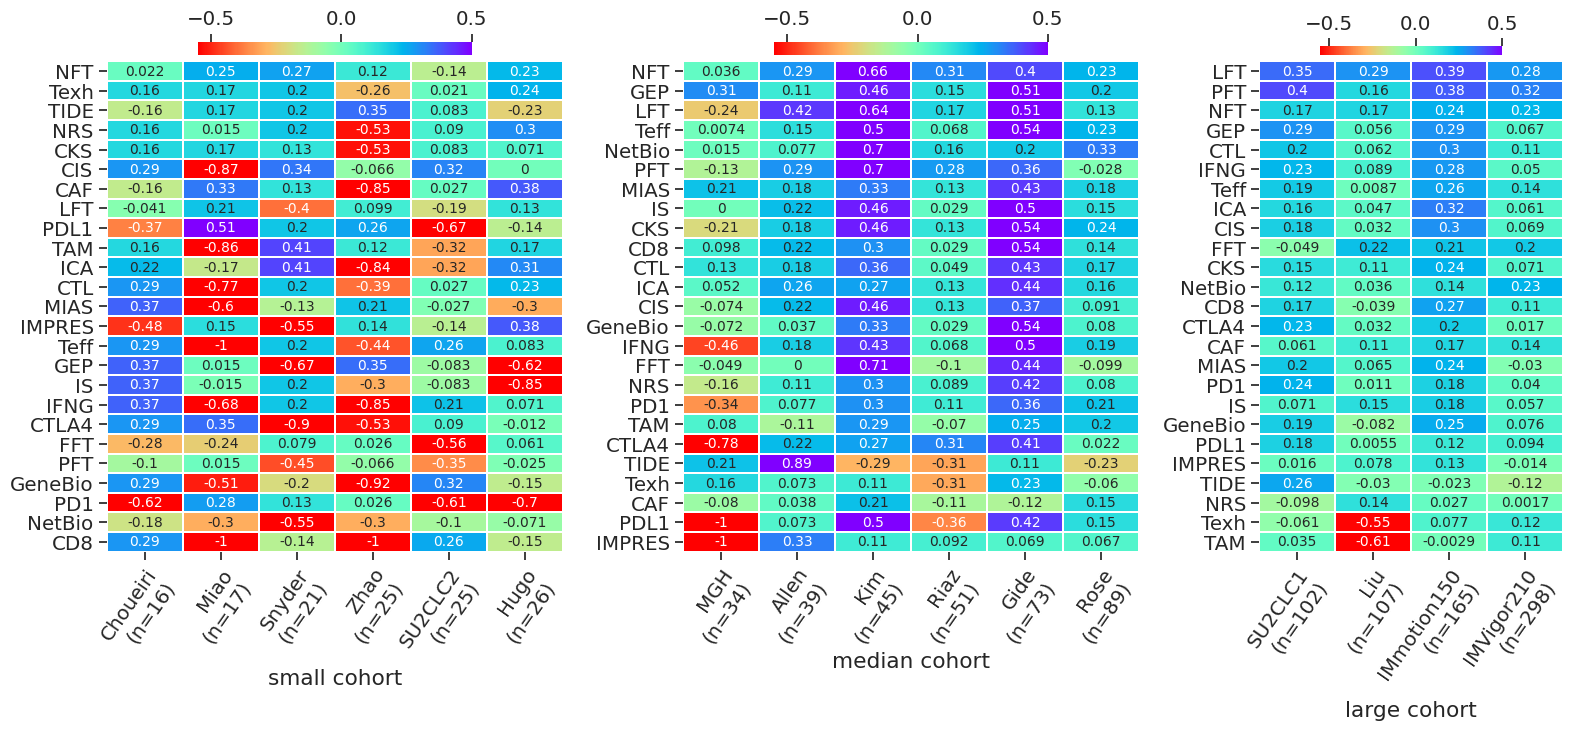

In [81]:
values = 'MCC'

fig,axes = plt.subplots(figsize=(16,8), ncols=3, sharey=False, width_ratios = [6,6,4])
ax1, ax2, ax3 = axes


for s, ax in zip(['small', 'median', 'large'], axes):
    
    dfp1 = dfp[dfp['size_map'] == s]
    x_order = dfp1.sort_values('size').cohort.unique()
    data2d = pd.pivot_table(dfp1, index='mode', columns = 'cohort', values = values)
    modes = dfp1.groupby('mode')[values].mean().sort_values(ascending=False).index.to_list()
    data2d = data2d[x_order]
    data2d = data2d.loc[modes]

    cbar_kws=dict(location="top",pad=0.01,shrink=0.6)
    #
    sns.heatmap(data2d, cmap = 'rainbow_r', ax=ax, cbar_kws = cbar_kws, vmax = -0.5, vmin = 0.5, 
                linewidths = 0.1, annot=True, annot_kws = {'fontsize':10})
    
    ax.tick_params(axis='both', which='major', right = False, top=False, direction = 'out',reset = True)
    
    ax.set_xticklabels(
        x_order, 
        rotation=55, 
        ha="right",  
        rotation_mode="anchor")  # <====== HERE is the ke
    
    ax.set_xlabel('%s cohort' % s)
    ax.set_ylabel('')
    
    # ax.set_ylim(0,1)

#ax.set_title('LOO %s' % values)

fig.tight_layout()

In [87]:
df_label.groupby(['cohort', 'response_label']).size().unstack()

response_label,NR,R
cohort,,
Allen,26,13
Choueiri,13,3
Gide,33,40
Hugo,12,14
IMVigor210,230,68
IMmotion150,117,48
Kim,33,12
Liu,66,41
MGH,22,12
